In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
import os
import librosa
from scipy.io import wavfile
from scipy import signal
import scipy
from scipy.fftpack import dct
from IPython.display import Audio
from PIL import Image

In [14]:
# Parameters used on tablet 
VOICED_THRESHOLD = 20000000
FRAME_SETBACK = 2
FS = 48000
DOWN_SAMPLED_FS = 8000
NFFT = 256
NOVERLAP = -1
NFILT = 40
NUM_CEPS = 13
NN_DATA_COLS = 28
NN_DATA_ROWS = 12
PREEMPHASIS_B = 0.97
PIXEL_WIDTH = 400
PIXEL_HEIGHT = 300

In [15]:
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32(s/32768.0) for s in SD])

def soundDataToInt16(SD):
    return np.array( [np.int16(s*32768.0) for s in SD] )

def createButter(N, Wn, fs):
    num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=fs)
    return np.array([num[i]/den[i] for i in range(len(num))])

def createFIR(num_taps, cut_off, fs):
    return signal.firwin(num_taps, cut_off, fs=fs)

def displayFIR(filt):
    coef_str = "{" 
    for val in filt: 
        coef_str += str(val) + ", " 
    coef_str = coef_str[:-2] 
    coef_str += "};" 
    print("FIR a Coefficients")
    print(coef_str) 

def applyFIR(samples, filt):
    circBuf = np.zeros(len(filt))
    circBufIdx = 0
    filteredSamples = np.zeros(len(samples))
    num_taps = len(filt)

    for i in range(len(samples)):
        circBuf[circBufIdx] = samples[i]
        curr_val = 0

        for n in range(num_taps):
            curr_val += filt[n] * circBuf[ (((circBufIdx - n) % num_taps) + num_taps) % num_taps]

        filteredSamples[i] = curr_val 
        circBufIdx = (circBufIdx + 1) % num_taps

    return filteredSamples

def frameVoiced(frame, threshold):
    isVoiced = False
    sum = 0
    for i in range(len(frame)):
        sum += abs(frame[i])**2

    if (sum > threshold):
        isVoiced = 1
    
    return isVoiced

def trimSamples(samples, frameSize, nfft, noverlap, threshold, frame_setback):
    num_samples = len(samples)
    if (noverlap < 0):
        noverlap = int(nfft/2)

    step = nfft - noverlap

    numFrames = math.ceil(num_samples / step)

    while ((numFrames - 1)*step + (nfft - 1) >= num_samples):
        numFrames -= 1

    first_frame = 0
    for i in range(numFrames):
        if frameVoiced(soundDataToInt16(samples[i*step:i*step + nfft]), threshold=threshold):
            first_frame = i
            break
    
    first_frame -= frame_setback
    if first_frame < 0:
        first_frame = 0
    last_frame = first_frame + frameSize
    num_trimmed_samples = ((last_frame - 1)*step + nfft) - (first_frame*step)
    trimmed_samples = np.zeros(num_trimmed_samples)

    for i in range(num_trimmed_samples):
        if (first_frame*step + i >= len(samples)):
            break
        trimmed_samples[i] = samples[first_frame*step + i]

    return trimmed_samples

def createImage(data, pixel_width, pixel_height, data_rows, data_cols, filename=None):
    def hex_to_rgb(val):
        mask = 0x0000FF
        b = mask & val
        g = mask & (val >> 8)
        r = mask & (val >> 16)
        
        return (r,g,b)

    viridis_pallete = [
        0x440154,
        0x481567,
        0x482677,
        0x453771,
        0x404788,
        0x39568C,
        0x33638D,
        0x2D708E,
        0x287D8E,
        0x238A8D,
        0x1F968B,
        0x20A387,
        0x29AF7F,
        0x3CBB75,
        0x55C667,
        0x73D055,
        0x95D840,
        0xB8DE29,
        0xDCE319,
        0xFDE725
    ]
    viridis_pallete_rgb = [hex_to_rgb(x) for x in viridis_pallete]
    viridis_size = len(viridis_pallete_rgb)

    max_val = None
    min_val = None
    for y in range(data_rows):
        for x in range(data_cols):
            sample = data[y,x]
            if math.isnan(sample):
                sample = 0
                data[y,x] = sample
            if max_val == None or sample > max_val:
                max_val = sample
            if min_val == None or sample < min_val:
                min_val = sample

    max_val -= min_val
    data = (data-min_val) / max_val

    """ canvas for holding rgb image from the range 0 to 255 """
    canvas = np.zeros((pixel_height, pixel_width, 3), dtype=np.uint8)
    horizontal_step = int(pixel_width / data_cols)
    vertical_step = int(pixel_height / data_rows)

    # attempting to only manipulate green in rgb

    # step counters that are 1 indexed
    horizontal_count = 1
    vertical_count = 1
    for pixel_row in range(pixel_height):
        if (pixel_row >= vertical_count * vertical_step) and (vertical_count < data_rows):
            vertical_count += 1

        horizontal_count = 1
        for pixel_col in range(pixel_width):
            if (pixel_col >= horizontal_count * horizontal_step) and (horizontal_count < data_cols):
                horizontal_count += 1
            
            # 0 index
            x_idx = horizontal_count - 1
            y_idx = data_rows - vertical_count

            # determine green value from data
            percent = data[y_idx, x_idx]

            viridis_idx = int((viridis_size-1) * percent)
            curr_color = viridis_pallete_rgb[viridis_idx]

            red_val = curr_color[0]
            green_val = curr_color[1]
            blue_val = curr_color[2]
            
            canvas[pixel_row, pixel_col, 0] = red_val
            canvas[pixel_row, pixel_col, 1] = green_val
            canvas[pixel_row, pixel_col, 2] = blue_val

    im = Image.fromarray(canvas)
    if filename is not None:
        im.save(filename) # if you wanted to save the image

    return im

In [16]:
# Now that the tablet is capable of saving WAV files, we can use the WAV file reader function
date = "Sun Apr 30 19:35:03 CDT 2023"
raw_wav_audio = "AndroidSavedFiles/raw_wav_audio/{}_raw_audio.wav".format(date)
trimmed_wav_audio = "AndroidSavedFiles/trimmed_wav_audio/{}_trimmed_audio.wav".format(date)
mfcc_image = "AndroidSavedFiles/mfcc_images/{}_mfcc.png".format(date)

raw_fs, raw_wav_audio = wavfile.read(raw_wav_audio)
trimmed_fs, trimmed_wav_audio = wavfile.read(trimmed_wav_audio)
mfcc_image = Image.open(mfcc_image)

In [17]:
Audio(raw_wav_audio, rate=raw_fs)

In [18]:
Audio(trimmed_wav_audio, rate=trimmed_fs)

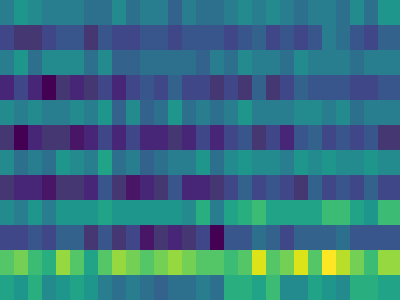

In [19]:
mfcc_image.show() # use this for a more detailed breakdown of the image
display(mfcc_image)


(eog:12140): Gtk-WARNING **: 20:53:47.700: GTK+ module /usr/lib/x86_64-linux-gnu/gtk-2.0/modules/libgail.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 20:53:47.700: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.

(eog:12140): Gtk-WARNING **: 20:53:47.723: GTK+ module /usr/lib/x86_64-linux-gnu/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 20:53:47.723: Failed to load module "canberra-gtk-module"

(eog:12140): Gtk-WARNING **: 20:53:47.724: GTK+ module /usr/lib/x86_64-linux-gnu/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 20:53:47.724: Failed to load module "canberra-gtk-module"


curr_processed shape: (12, 28)


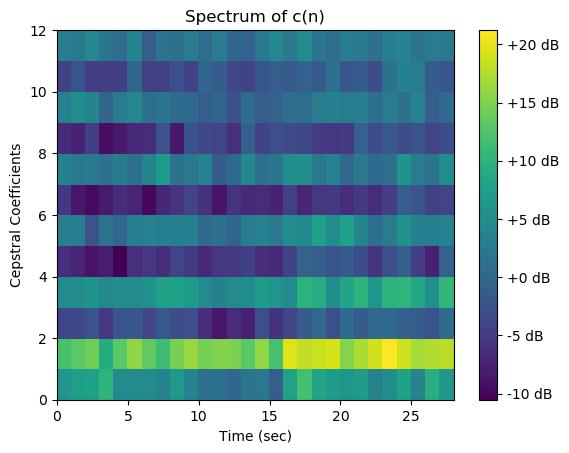

In [20]:
sig = soundDataToFloat(raw_wav_audio)

filt = createFIR(51, 3500, fs=raw_fs)
filtered_sig = applyFIR(sig, filt)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])

filtered_sig = trimSamples(filtered_sig, NN_DATA_COLS, NFFT, NOVERLAP, VOICED_THRESHOLD, FRAME_SETBACK)

curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), DOWN_SAMPLED_FS, NFFT, NOVERLAP, 2, PREEMPHASIS_B, NFILT, NUM_CEPS), copy=False)[1:,:]
# curr_processed = np.array(myMatrix.MFCC_Matrix_float(list(filtered_sig), DOWN_SAMPLED_FS, NFFT, NOVERLAP, 2, PREEMPHASIS_B, NFILT, NUM_CEPS), copy=False)[1:,:]
print("curr_processed shape: {}".format(curr_processed.shape))

t_time = NN_DATA_COLS / DOWN_SAMPLED_FS
data = np.zeros((NN_DATA_ROWS, NN_DATA_COLS))
for row in range(NN_DATA_ROWS):
    for col in range(NN_DATA_COLS):
        data[row,col] = curr_processed[row,col]

# data -= np.mean(data, axis=0)

t = np.linspace(0, t_time, NN_DATA_COLS)
n = np.arange(NN_DATA_ROWS)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
# plt.pcolormesh(curr_processed[1:,:])
plt.pcolormesh(data)
plt.colorbar(format="%+2.f dB")

## Generating your own image
The code below uses a custom function I made to create your own image based on the values from a 2d data array

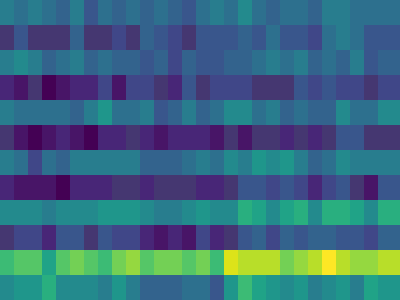

In [21]:
im = createImage(data, PIXEL_WIDTH, PIXEL_HEIGHT, data.shape[0], data.shape[1])
display(im)

## Testing Librosa MFCC vs My MFCC

librosa shape: (13, 27)
processed shape: (12, 28)
pcolormesh m_slaney shape: (12, 27)


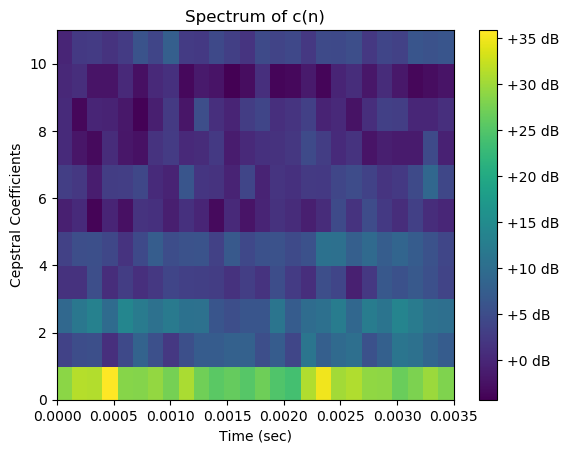

In [22]:
# m_slaney = librosa.feature.mfcc(y=filtered_sig, n_mfcc=13, sr=8000, dct_type=2, norm='ortho', lifter=0, n_fft=256, n_mels=40, center=False, power=1, fmax=None, hop_length=int(256/2+1), window=scipy.signal.windows.hann)
m_slaney = librosa.feature.mfcc(y=filtered_sig, n_mfcc=13, sr=8000, dct_type=2, norm="ortho", lifter=0, n_fft=256, n_mels=40, center=False, power=1, fmax=None, hop_length=int(256/2+1), window=scipy.signal.windows.hann)
print("librosa shape: {}".format(m_slaney.shape))
print("processed shape: {}".format(curr_processed.shape))

plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
m_slaney = m_slaney[1:, :NN_DATA_COLS]
print("pcolormesh m_slaney shape: {}".format(m_slaney.shape))
t_slaney = np.linspace(0, t_time, m_slaney.shape[1])
plt.pcolormesh(t_slaney, [n for n in range(m_slaney.shape[0])], m_slaney)
plt.colorbar(format="%+2.f dB")

shape pow_frames: (129, 28)
shape fbank: (40, 129)
filter_bank shape: (40, 28)
dct_banks shape: (13, 40)
np eps: 2.220446049250313e-16
shape mfcc: (13, 28)
final mfcc shape: (12, 28)


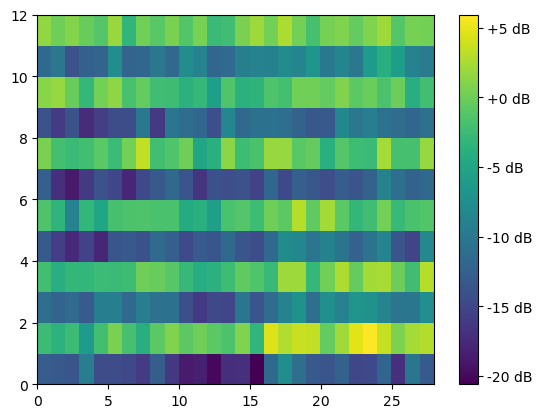

In [23]:
hann_win = scipy.signal.hann(256, sym=True)
scale = 1.0 / ((hann_win).sum() ** 2)
scale = np.sqrt(scale)
NFILT = 40

emphasized_signal = np.append(filtered_sig[0], filtered_sig[1:] - PREEMPHASIS_B * filtered_sig[:-1])

noverlap = int(NFFT/2)
step = NFFT - noverlap
num_ffts = math.ceil(len(emphasized_signal) / step)

while( (num_ffts - 1) * step + (NFFT - 1) >= len(emphasized_signal) ):
    num_ffts -= 1

pow_frames_size = int(num_ffts * (NFFT/2 + 1))
pow_frames = np.zeros((int(NFFT/2+1), num_ffts))
for frame in range(num_ffts):
    start_idx = frame * step
    end_idx = start_idx + NFFT
    rfft_result = np.fft.rfft(emphasized_signal[start_idx:end_idx] * np.hanning(NFFT))
    pow_frames[:, frame] = (np.absolute(rfft_result)**2)/NFFT

low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (DOWN_SAMPLED_FS / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, NFILT + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / DOWN_SAMPLED_FS)

fbank = np.zeros((NFILT, int(np.floor(NFFT / 2 + 1))))
for m in range(1, NFILT + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

# pow_frames = pow_frames
# fbank = fbank
print("shape pow_frames: {}".format(pow_frames.shape))
print("shape fbank: {}".format(fbank.shape))
# filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = fbank @ pow_frames
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = np.log10(filter_banks)  # dB
# filter_banks = filter_banks
print("filter_bank shape: {}".format(filter_banks.shape))

M = filter_banks.shape[0]
n = np.zeros((13, 1))
n[:,0] = np.arange(13)
m = np.arange(40)
dct_banks = np.cos((np.pi*n*(m - 0.5))/M)
print("dct_banks shape: {}".format(dct_banks.shape))
# mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
mfcc = dct_banks @ filter_banks
# mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

print("np eps: {}".format(np.finfo(float).eps))
print("shape mfcc: {}".format(mfcc.shape))
mfcc = mfcc[1:,:]
print("final mfcc shape: {}".format(mfcc.shape))
plt.pcolormesh(mfcc)
plt.colorbar(format="%+2.f dB")

In [24]:
# printing the FIR filter coefficients to use on the Android tablet
displayFIR(filt)

FIR a Coefficients
{-0.0009154526549517794, -0.0011114542578674472, -0.0011748111621119072, -0.0009912202839374121, -0.00040566875669237703, 0.0006928645047039383, 0.0022655744122396246, 0.004040327999447895, 0.005495567242988037, 0.005941591839728333, 0.004700288764397637, 0.0013495643820975742, -0.004031166285818187, -0.010692574509175845, -0.017194526140070547, -0.021572582846390315, -0.021684691762467997, -0.015679166273036733, -0.002483205556162394, 0.017807916482357168, 0.043749754550979104, 0.07264355863368925, 0.10091303015030824, 0.12470091418085558, 0.14056680266815558, 0.14613752935346994, 0.14056680266815555, 0.12470091418085556, 0.10091303015030822, 0.07264355863368924, 0.0437497545509791, 0.01780791648235716, -0.0024832055561623935, -0.015679166273036726, -0.021684691762467987, -0.021572582846390312, -0.017194526140070544, -0.01069257450917584, -0.004031166285818185, 0.0013495643820975731, 0.004700288764397637, 0.005941591839728333, 0.005495567242988034, 0.004040327999447